In [68]:
from scipy.stats import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats.power import TTestIndPower

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [ ]:
#Подгружаем данные с гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_excel('/content/drive/MyDrive/Документы/GB/AB_Test_Results.xlsx')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Получим сводную информацию по таблице.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Столбец с названием тестовых групп имеет тип данных object. Столбцы c USER_ID и REVENUE относятся к числовому типу данных.

Узнаем количество пользователей в группах.

In [11]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Получим предварительные данные по обеим группам.

In [13]:
df[df['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


In [12]:
df[df['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


Предварительно получаем, что максимальный доход в основной группе больше, чем в тестовой. То же самое можно сказать о среднем значении дохода.

Определим, есть ли пользователи, которые попали в обе группы.

In [29]:
v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})
v.head()

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1


Полученный результат показывает, что есть пользователи, которые находятся сразу в двух группах. Для корректной оценки теста уберем данные о таких пользователях.

In [33]:
# Создадим переменную, которая будет содержать данные о пользователях, находящихся в обеих группах
more_than_one_types = v.query('VARIANT_NAME > 1')

# Обновим наш DataFrame 
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

На всякий случай сравним новые данные со старыми.

In [34]:
# Количество строк и столбцов в новом DataFrame
df_new.shape

(6070, 3)

In [38]:
# Количество строк и столбцов в старом DataFrame
df.shape

(10000, 3)

Выведем количество пользователей для нового DataFrame.

In [55]:
df_new.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3026.0,0.155506,3.708620,0.0,0.0,0.0,0.0,196.01
variant,3044.0,0.058909,0.760344,0.0,0.0,0.0,0.0,23.04


Проверим на нормальное распределение. Поскольку количество пользователей меньше 5000, то можно воспользоваться методом Шапиро-Уилка.

In [56]:
from scipy.stats import shapiro
import scipy.stats as stats

In [42]:
alpha = 0.05

st = shapiro(df_new.REVENUE)
print('Распределение является {}нормальным.\n'.format( {True:'не',
False:''}[st[1] < alpha]));

Распределение является ненормальным.



Для наглядности построим график.

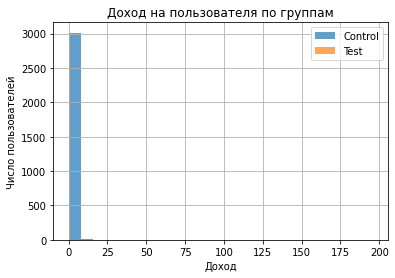

In [64]:
control = df_new.query('VARIANT_NAME == "control"')
test = df_new.query('VARIANT_NAME == "variant"')
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Итак, имеем две тестируемые группы, которые являются независимыми и не подчиняются закону нормального распределения. Поэтому для оценки АВ-теста используем критерий Манна-Уитни.

In [61]:
stats.mannwhitneyu(x=df_new[(df_new['VARIANT_NAME'] == 'control')]['REVENUE'].values, 
                   y=df_new[(df_new['VARIANT_NAME'] == 'variant')]['REVENUE'].values)


MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

### Промежуточные выводы
Сравнивая полученное значение p-value со значением ошибки первого рода (0,05), можно сделать вывод, что стаститически значимой разности между группами нет.

### Расчет мощности теста


*В лекции записи были лаконичнее, но, разнообразия ради, сделаем их подлиннее.*

In [77]:
# Расчет средних значений в группах
C_mean = df_new[(df_new['VARIANT_NAME'] == 'control')]['REVENUE'].values.mean()
T_mean = df_new[(df_new['VARIANT_NAME'] == 'variant')]['REVENUE'].values.mean()

# Расчет стандартного отклонения в группах
C_std = df_new[(df_new['VARIANT_NAME'] == 'control')]['REVENUE'].values.std()
T_std =  df_new[(df_new['VARIANT_NAME'] == 'variant')]['REVENUE'].values.std()

In [78]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)
ef =float((T_mean-C_mean)/ S) 

In [79]:
n = len(df_new[(df_new['VARIANT_NAME'] == 'control')]['REVENUE'].values)

In [105]:
# Зададим значение ошибки первого рода
alpha = 0.05 

# Расчитаем мощность теста
analysis = TTestIndPower()
test_power = analysis.solve_power(ef, power=None, nobs1=n, ratio=1.0, alpha=alpha)

print('Мощность теста',(round(test_power,1)*100),'%')

Мощность теста 30.0 %


### Выводы (окончательные)
1.   Между группами отсутствует статистически значимая разность.
2.   Во время теста часть пользователей находилась в обеих группах.
3. Мощность теста слишком мала, чтобы полагаться на его результаты.

Рекомендации менеджеру: провести тест еще раз или плюнуть на это все и пойти пить пиво.